In [1]:
# !pip install gtts gradio
# !brew install ffmpeg  # macOS (Homebrew)
# !pip install openai-whisper ffmpeg-python
# !pip install sounddevice
#!pip install git+https://github.com/openai/whisper.git

** Import Libraries & Dependencies **

In [ ]:
# Standard Libraries
import os
import re

# Data Handling and Processing
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns  

# Scikit-Learn: Preprocessing and Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV

# Scikit-Learn: Models
from sklearn.ensemble import RandomForestClassifier

# Scikit-Learn: Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)

# Scikit-Learn: Feature Engineering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

# Imbalanced Data Handling
from imblearn.combine import SMOTEENN

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Concatenate, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Joblib (for saving/loading models)
import joblib

# Gradio and TTS
import gradio as gr
import speech_recognition as sr
from gtts import gTTS
import whisper
import sounddevice as sd  # Handles microphone input
import wave  # Built-in module for saving WAV files

** Load the data **

In [3]:
# 1. Load and examine the data
disease_symptoms_data = pd.read_csv('Resources/disease_symptoms.csv')


** Explore the data **

In [4]:
disease_symptoms_data.head()

,Disease,Symptoms
0,Malaria,"fever, headache, weakness, cough, vomiting"
1,Flu,"fever, headache, runny nose, muscle aches, fat..."
2,Measles,"fever, red rash, conjunctivitis, cough, rhinitis"
3,Pneumonia,"sputum production, fever, chest pain, cough, c..."
4,Tinnitus,"hissing, buzzing, clicking, roaring, ringing i..."


In [5]:
#list Symptoms
disease_symptoms_data['Symptoms'].unique()

array(['fever, headache, weakness, cough, vomiting',
       'fever, headache, runny nose, muscle aches, fatigue',
       'fever, red rash, conjunctivitis, cough, rhinitis',
       'sputum production, fever, chest pain, cough, chills, fatigue, shortness of breath',
       'hissing, buzzing, clicking, roaring, ringing in the ears',
       'vomiting, headache, fatigue, agitation',
       'frequent urination, inability to sleep through the night without urinating, urinary leakage, difficulty urinating',
       'respiratory disorder, vomiting, rapid pulse, diarrhea, low blood pressure, malaise, runny nose, abdominal pain, eczema',
       'hair loss, gradual thinning of hair',
       'disorientation in time, memory loss',
       'swollen tonsils, fever, difficulty swallowing, sore throat',
       'headache, hot flashes, absence of menstruation',
       'dry skin, hair loss, weight gain, sexual dysfunction, decreased muscle mass and strength, decreased testicular volume',
       'breathing di

** Find a method to separate the symptoms from the disease column and create a new column for each symptom. **

In [6]:
# Expand the dataset while maintaining symptom relationships

def expand_dataset_simple(df):

    expanded_data = []
    
    for _, row in df.iterrows():
        disease = row['Disease']
        symptoms = row['Symptoms']
        
        # Clean symptoms
        symptoms = re.sub(r'[\[\]\'"]', '', symptoms)
        symptom_list = [s.strip().lower() for s in symptoms.split(',')]
        symptom_list = [s for s in symptom_list if s]
        
        # Original entry
        original_symptoms = ', '.join(symptom_list)
        expanded_data.append({
            'Disease': disease,
            'Symptoms': original_symptoms
        })
        # Create 5 variations for each disease
        for _ in range(5):
            if len(symptom_list) > 3:
                # Keep 80% of symptoms, randomly selected
                n_symptoms = max(3, int(0.8 * len(symptom_list)))
                selected_symptoms = np.random.choice(symptom_list, size=n_symptoms, replace=False)
            else:
                # For few symptoms, use all but in different order
                selected_symptoms = np.random.permutation(symptom_list)
            
            expanded_data.append({
                'Disease': disease,
                'Symptoms': ', '.join(selected_symptoms)
            })
    
    return pd.DataFrame(expanded_data)      

** Expand the dataset so lengths match so we can move forward with processing **

In [7]:
# Create expanded dataset
expanded_df = expand_dataset_simple(disease_symptoms_data)
print(f"Original dataset size: {len(disease_symptoms_data)}")
print(f"Expanded dataset size: {len(expanded_df)}")

Original dataset size: 108
Expanded dataset size: 648


** Increase the min/max samples **

In [8]:
# Print distribution of samples
disease_counts = expanded_df['Disease'].value_counts()
print("\nSamples per disease:")
print(f"Minimum samples: {disease_counts.min()}")
print(f"Maximum samples: {disease_counts.max()}")
print(f"Average samples: {disease_counts.mean():.1f}")


Samples per disease:
Minimum samples: 6
Maximum samples: 6
Average samples: 6.0


** Symptom Frequency Distribution **

C:\Users\Sami\AppData\Local\Temp\ipykernel_37228\150607326.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
C:\Users\Sami\AppData\Local\Temp\ipykernel_37228\150607326.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')


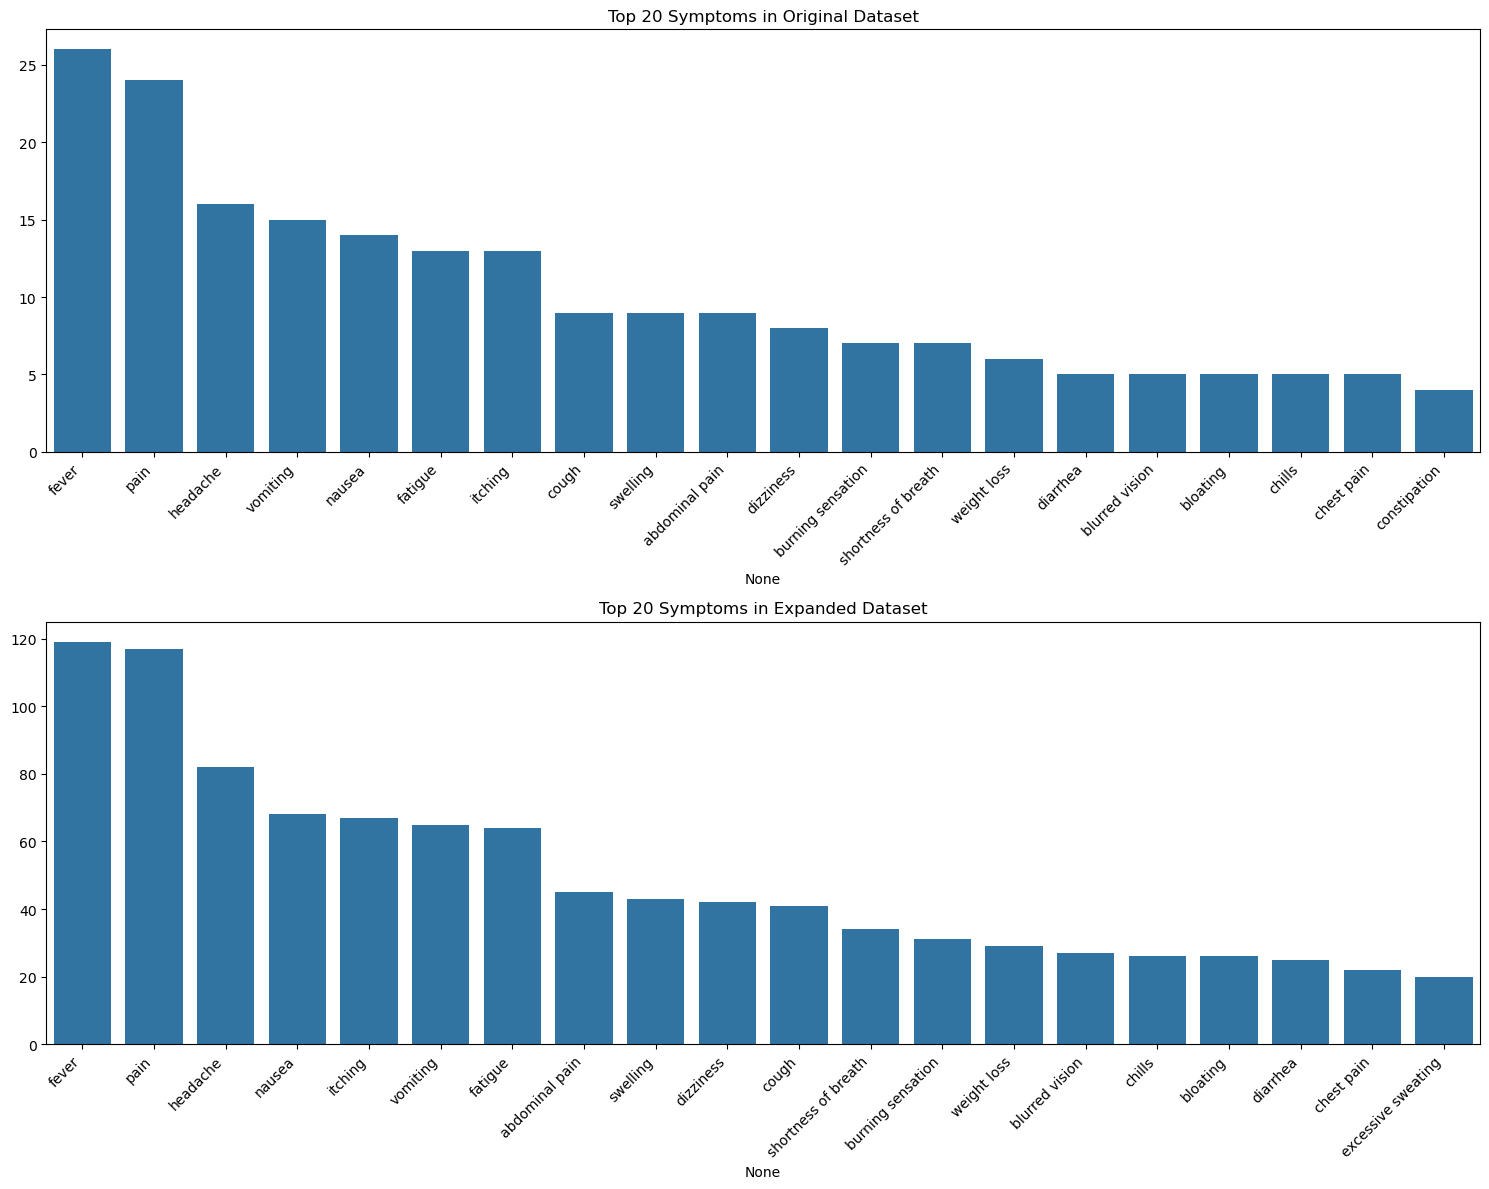


Plotting symptom distributions...


In [9]:
# Compare symptom frequency distributions between datasets
def plot_symptom_distributions(original_df, expanded_df):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Function to get symptom frequencies
    def get_symptom_freq(df):
        all_symptoms = []
        for symptoms in df['Symptoms']:
            all_symptoms.extend([s.strip() for s in symptoms.split(',')])
        return pd.Series(all_symptoms).value_counts()
    
    # Original dataset
    orig_freq = get_symptom_freq(original_df)
    sns.barplot(x=orig_freq.head(20).index, y=orig_freq.head(20).values, ax=ax1)
    ax1.set_title('Top 20 Symptoms in Original Dataset')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    
    # Expanded dataset
    exp_freq = get_symptom_freq(expanded_df)
    sns.barplot(x=exp_freq.head(20).index, y=exp_freq.head(20).values, ax=ax2)
    ax2.set_title('Top 20 Symptoms in Expanded Dataset')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

    print("\nPlotting symptom distributions...")
plot_symptom_distributions(disease_symptoms_data, expanded_df)

** Disease - Symptom Heatmap **


Creating disease-symptom heatmap...


C:\Users\Sami\AppData\Local\Temp\ipykernel_37228\1457022573.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3408319960368022' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  disease_symptom_matrix.loc[disease] = disease_vector.mean(axis=0).A1
C:\Users\Sami\AppData\Local\Temp\ipykernel_37228\1457022573.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3776495818573861' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  disease_symptom_matrix.loc[disease] = disease_vector.mean(axis=0).A1
C:\Users\Sami\AppData\Local\Temp\ipykernel_37228\1457022573.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.29033105143260834' has dtype incompatible with int64, 

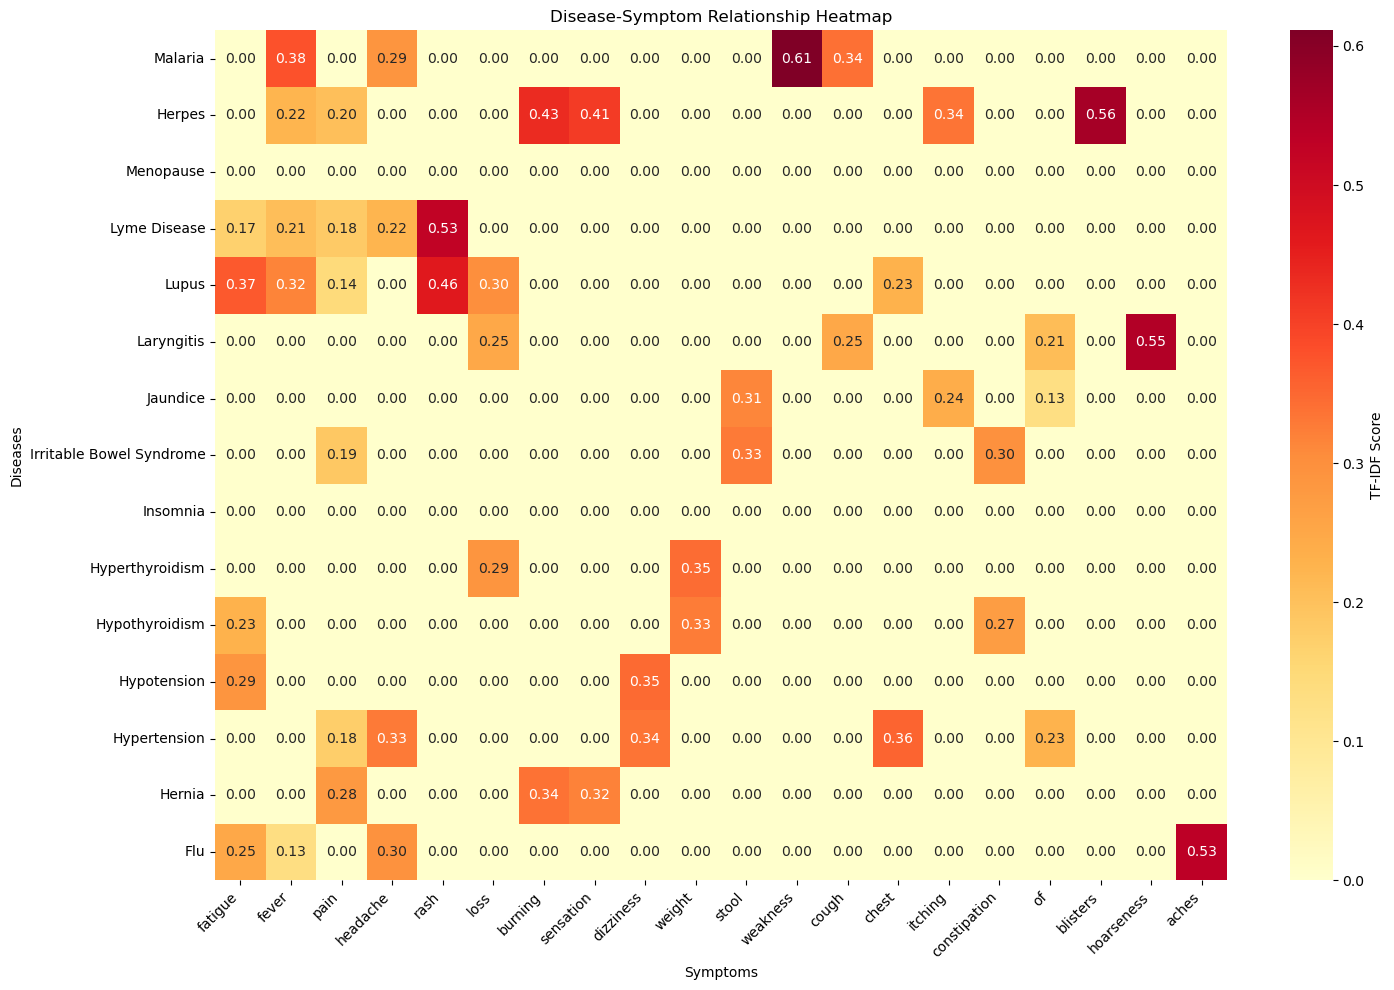

In [10]:
def create_disease_symptom_heatmap(df, top_n_diseases=15, top_n_symptoms=20):
    """
    Creates a heatmap showing the relationship between diseases and symptoms
    """
    # Get top diseases by frequency
    top_diseases = df['Disease'].value_counts().head(top_n_diseases).index
    
    # Create TF-IDF vectorizer
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df['Symptoms'])
    feature_names = vectorizer.get_feature_names_out()
    
    # Create disease-symptom matrix
    disease_symptom_matrix = pd.DataFrame(0, 
                                        index=top_diseases,
                                        columns=feature_names)
    
    for disease in top_diseases:
        disease_symptoms = df[df['Disease'] == disease]['Symptoms']
        disease_vector = vectorizer.transform(disease_symptoms)
        disease_symptom_matrix.loc[disease] = disease_vector.mean(axis=0).A1
    
    # Select top symptoms by importance
    top_symptoms = disease_symptom_matrix.sum().nlargest(top_n_symptoms).index
    
        # Plot heatmap
    plt.figure(figsize=(15, 10))
    sns.heatmap(disease_symptom_matrix[top_symptoms], 
                cmap='YlOrRd', 
                annot=True, 
                fmt='.2f',
                cbar_kws={'label': 'TF-IDF Score'})
    plt.title('Disease-Symptom Relationship Heatmap')
    plt.xlabel('Symptoms')
    plt.ylabel('Diseases')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

print("\nCreating disease-symptom heatmap...")
create_disease_symptom_heatmap(expanded_df)

** Preprocess the data so the symptoms column  keeps together the words necesary to express common medical phrases, while removing the commas. **

In [11]:
# Preprocess and clean symptom text by removing stopwords and preserving important medical phrases
def preprocess_symptoms(text):

    if not isinstance(text, str):
        return ''


        # Define common medical phrases that should be kept together
    medical_phrases = [
        'pain in the chest',
        'chest pain',
        'shortness of breath',
        'ringing in the ears',
        'swelling of the joints',
        'pain in my right hand',
        'burning sensation in the chest',
        'shortness of breath on exertion',
        'difficulty in breathing',
        'loss of voice',
        'loss of height',
        'loss of appetite',
        'thinning of hair',
        'disorientation in time',
        'inability to sleep',
        'sensitivity to light',
        'burning sensation in the sternum',
        'bitter or sour taste',
        'difficulty establishing contact',
        'absence of gas',
        'absence of bowel movements',
        'bleeding outside menstruation',
        'difficulty breathing',
        'pain in the back',
        'back pain',
        'swelling of the joints',
        'joint swelling',
        'pain in the right hand',
        'right hand pain',
        'pain in the left hand',
        'left hand pain',
        'loss of appetite',
        'difficulty swallowing',
        'ringing in the ears',
        'blurred vision',
        'high blood pressure',
        'low blood pressure',
        'rapid heart rate',
        'irregular heartbeat',
        'muscle weakness',
        'chronic fatigue',
        'night sweats',
        'weight loss',
        'weight gain',
        'joint pain',
        'muscle pain',
        'sore throat',
        'runny nose',
        'stuffy nose',
        'abdominal pain',
        'stomach pain',
        'lower back pain',
        'upper back pain',
        'neck pain',
        'shoulder pain'
    ]
    
     
    # Sort phrases by length (longest first) to ensure longer phrases are matched before shorter ones
    medical_phrases.sort(key=len, reverse=True)

    # Clean the text
    text = re.sub(r'[\[\]\'\"]', '', text.lower())
    
    # Replace spaces with underscores in medical phrases
    for phrase in medical_phrases:
        if phrase in text:
            text = text.replace(phrase, phrase.replace(' ', '_'))

        # Split by commas and clean each symptom
    symptoms = [s.strip() for s in text.split(',')]
    
    # Define stopwords to remove (excluding those that might be important in medical context)
    stopwords = {'and', 'or', 'the', 'a', 'an', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by'}
    
    # Process each symptom
    cleaned_symptoms = []
    for symptom in symptoms:
        # Skip empty symptoms
        if not symptom:
            continue

            
        # If symptom contains underscores (preserved phrase), keep as is
        if '_' in symptom:
            cleaned_symptoms.append(symptom)
            continue
            
        # Otherwise, split into words and remove stopwords
        words = symptom.split()
        words = [w for w in words if w not in stopwords]
        if words:
            cleaned_symptoms.append(' '.join(words))
    
    # Join all symptoms and replace underscores back with spaces
    result = ' '.join(cleaned_symptoms)
    for phrase in medical_phrases:
        result = result.replace(phrase.replace(' ', '_'), phrase)
    
    return result



** Test to see if the preprocessing worked **

In [12]:
test_text = "pain in the chest, swelling of the joints, difficulty in breathing"
print("Original:", test_text)
print("Cleaned:", preprocess_symptoms(test_text))

Original: pain in the chest, swelling of the joints, difficulty in breathing
Cleaned: pain in the chest swelling of the joints difficulty in breathing


**Expand the Symptoms column to produce a more balanced dataset since SMOTE and SMOTEEN were not effective.**

In [13]:
expanded_df.head(60)

,Disease,Symptoms
0,Malaria,"fever, headache, weakness, cough, vomiting"
1,Malaria,"weakness, headache, cough, fever"
2,Malaria,"fever, vomiting, cough, weakness"
3,Malaria,"cough, weakness, vomiting, fever"
4,Malaria,"vomiting, headache, weakness, fever"
5,Malaria,"fever, weakness, headache, vomiting"
6,Flu,"fever, headache, runny nose, muscle aches, fat..."
7,Flu,"fever, muscle aches, runny nose, headache"
8,Flu,"muscle aches, headache, fatigue, fever"
9,Flu,"headache, runny nose, muscle aches, fatigue"


In [14]:
# Create features and target
X = expanded_df['Symptoms'].apply(preprocess_symptoms)
y = expanded_df['Disease']

In [15]:
# Create TF-IDF features
vectorizer = TfidfVectorizer(
    max_features=500,
    min_df=1,
    max_df=0.95,
    ngram_range=(1, 2)
)

X_vectorized = vectorizer.fit_transform(X)
print(f"\nFeature matrix shape: {X_vectorized.shape}")



Feature matrix shape: (648, 500)


In [16]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_vectorized, y,
    test_size=0.2,
    random_state=42
)

In [17]:
# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

In [18]:
# Fit the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

In [19]:
# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)

In [20]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.3f}")


Model Accuracy: 0.938


In [21]:
# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
                           precision    recall  f1-score   support

               Acetonemia       1.00      1.00      1.00         2
                 Alopecia       1.00      1.00      1.00         1
               Amenorrhea       1.00      1.00      1.00         2
                  Amnesia       1.00      1.00      1.00         3
               Andropause       1.00      0.67      0.80         3
          Angina Pectoris       1.00      1.00      1.00         3
                  Angioma       1.00      1.00      1.00         1
                 Anorexia       0.00      0.00      0.00         1
                   Anuria       1.00      1.00      1.00         3
                  Anxiety       1.00      1.00      1.00         1
             Appendicitis       1.00      1.00      1.00         3
                   Asthma       1.00      1.00      1.00         2
                   Autism       1.00      1.00      1.00         1
                 Cataract       1.00 

c:\Users\Sami\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Sami\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Sami\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Sami\anaconda3\Lib\site-packages\sklearn\m

** Create a function that dictates how the model will handle inputs and outputs**

In [22]:
#  Make  a definition for disease predictions and suggest additional symptoms to look for.
def predict_disease(symptoms, confidence_threshold=0.30):

    # Define medical phrases that should be preserved
    medical_phrases = [
        'pain in the chest',
        'shortness of breath',
        'ringing in the ears',
        'swelling of the joints',
        'pain in my right hand',
        'burning sensation in the chest',
        'difficulty in breathing',
        'loss of voice',
        'loss of height',
        'loss of appetite',
        'thinning of hair',
        'disorientation in time',
        'inability to sleep',
        'sensitivity to light',
        'shortness of breath on exertion'
        'burning sensation in the sternum',
        'bitter or sour taste',
        'difficulty establishing contact',
        'absence of gas',
        'absence of bowel movements',
        'shortness of breath on exertion',
        'pain in the chest',
        'chest pain',
        'shortness of breath',
        'ringing in the ears',
        'swelling of the joints',
        'pain in my right hand',
        'burning sensation in the chest',
        'difficulty in breathing',
        'loss of voice',
        'loss of height',
        'loss of appetite',
        'thinning of hair',
        'disorientation in time',
        'inability to sleep',
        'sensitivity to light',
        'burning sensation in the sternum',
        'bitter or sour taste',
        'difficulty establishing contact',
        'absence of gas',
        'absence of bowel movements',
        'bleeding outside menstruation',
        'difficulty breathing',
        'pain in the back',
        'back pain',
        'swelling of the joints',
        'joint swelling',
        'pain in the right hand',
        'right hand pain',
        'pain in the left hand',
        'left hand pain',
        'loss of appetite',
        'difficulty swallowing',
        'ringing in the ears',
        'blurred vision',
        'high blood pressure',
        'low blood pressure',
        'rapid heart rate',
        'irregular heartbeat',
        'muscle weakness',
        'chronic fatigue',
        'night sweats',
        'weight loss',
        'weight gain',
        'joint pain',
        'muscle pain',
        'sore throat',
        'runny nose',
        'stuffy nose',
        'abdominal pain',
        'stomach pain',
        'lower back pain',
        'upper back pain',
        'neck pain',
        'shoulder pain'
        'bleeding outside menstruation'
    ]
    
    # Preprocess symptoms
    processed_symptoms = preprocess_symptoms(symptoms)
    
    # Split input symptoms into a list while preserving phrases
    temp_text = processed_symptoms
    for phrase in medical_phrases:
        if phrase in temp_text:
            temp_text = temp_text.replace(phrase, phrase.replace(' ', '_'))
    
    input_symptoms = set()
    for symptom in temp_text.split():
        if '_' in symptom:
            # Convert back underscores to spaces for preserved phrases
            input_symptoms.add(symptom.replace('_', ' '))
        else:
            input_symptoms.add(symptom)
    
    # Get all known symptoms from the vectorizer
    known_symptoms = set(vectorizer.get_feature_names_out())
    
    # Check if there are any known symptoms in the input
    matching_symptoms = input_symptoms.intersection(known_symptoms)
    
    # Create a dictionary of all diseases and their symptoms from your original dataset
    disease_symptom_map = {}
    for _, row in disease_symptoms_data.iterrows():
        disease = row['Disease']
        # Process symptoms while preserving phrases
        temp_symptoms = preprocess_symptoms(row['Symptoms'])
        for phrase in medical_phrases:
            if phrase in temp_symptoms:
                temp_symptoms = temp_symptoms.replace(phrase, phrase.replace(' ', '_'))
        
        all_symptoms = set()
        for symptom in temp_symptoms.split():
            if '_' in symptom:
                all_symptoms.add(symptom.replace('_', ' '))
            else:
                all_symptoms.add(symptom)
        
        disease_symptom_map[disease] = all_symptoms
    
    # Vectorize
    X_new = vectorizer.transform([processed_symptoms])

    # Get probabilities
    proba = rf_model.predict_proba(X_new)[0]

    # Get all predictions with their probabilities
    predictions = []
    for idx, probability in enumerate(proba):
        disease = rf_model.classes_[idx]
        predictions.append((disease, probability))
    
    # Sort by probability
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Format output
    output = "Based on the symptoms you described:\n\n"
    output += f"Your symptoms: {', '.join(sorted(input_symptoms))}\n\n"
    
    # Add predictions with additional symptoms
    output += "Possible conditions and related symptoms to watch for:\n\n"
    
    for disease, prob in predictions[:3]:  # Show top 3 predictions
        # Get all symptoms for this disease
        disease_symptoms = disease_symptom_map.get(disease, set())
        
        # Find symptoms not mentioned by the user
        missing_symptoms = disease_symptoms - input_symptoms
        
        # Calculate symptom match percentage
        if disease_symptoms:
            match_percentage = len(input_symptoms.intersection(disease_symptoms)) / len(disease_symptoms) * 100
        else:    
            match_percentage = 0

        output += f"▶ {disease} (Confidence: {prob:.1%}, Symptom Match: {match_percentage:.0f}%)\n"
        
        if missing_symptoms:
            output += "   Additional symptoms to look for:\n"
            # Sort missing symptoms to ensure consistent output
            sorted_missing = sorted(missing_symptoms)
            output += "   • " + "\n   • ".join(sorted_missing) + "\n"
        else:
            output += "   ✓ All typical symptoms present\n"
        output += "\n"
    
    output += "\nImportant Notes:\n"
    output += "• The presence of additional symptoms may increase or decrease the likelihood of each condition\n"
    output += "• Some symptoms may be more significant than others for specific conditions\n"
    output += "• This is not a medical diagnosis - please consult a healthcare professional\n"
    
    return output

** Save the Model **

In [23]:
# Save the model
model_components = {
    'model': rf_model,
    'vectorizer': vectorizer
}
joblib.dump(model_components, 'disease_prediction_model.joblib')


['disease_prediction_model.joblib']

** Model Testing **

In [24]:
# Verify model and vectorizer are loaded
print("Model loaded:", rf_model is not None)
print("Vectorizer loaded:", vectorizer is not None)

Model loaded: True
Vectorizer loaded: True


In [25]:
# 1. Basic Model Testing
def test_model():
    """Test the model with various symptom combinations"""
    print("Testing Disease Prediction Model")
    print("=" * 50)
    
    # Test cases
    test_cases = [
        "fever, cough, headache",
        "joint pain, swelling, redness",
        "nausea, vomiting, dizziness",
        "chest pain, shortness of breath",
        "headache, blurred vision, dizziness"
    ]
    
    for symptoms in test_cases:
        print(f"\nTest Case: {symptoms}")
        print("-" * 50)
        
        # Get predictions
        result = predict_disease(symptoms)
        print(result)
        print("\n")


In [26]:
# 2. Test Edge Cases
def test_edge_cases():

    print("Testing Edge Cases")
    print("=" * 50)
    
    edge_cases = [
        "",  # Empty input
        "nonexistent symptom",  # Invalid symptom
        "fever",  # Single symptom
        "FEVER, COUGH, HEADACHE",  # All caps
        "fever,cough,headache",  # No spaces
        "   fever,    cough,   headache   "  # Extra spaces
    ]
    
    for case in edge_cases:
        print(f"\nEdge Case: '{case}'")
        print("-" * 50)
        try:
            result = predict_disease(case)
            print(result)
        except Exception as e:
            print(f"Error: {str(e)}")
        print("\n")


In [27]:
# 3. Test Real-World Scenarios
def test_real_scenarios():
    """Test with real-world symptom combinations"""
    print("Testing Real-World Scenarios")
    print("=" * 50)
    
    scenarios = [
        # Common cold symptoms
        "runny nose, sore throat, cough, mild fever",
        # Flu-like symptoms
        "high fever, body aches, fatigue, headache",
        # Allergic reaction
        "rash, itching, swelling, difficulty breathing",
        # Digestive issues
        "nausea, vomiting, abdominal pain, diarrhea"
    ]
    
    for scenario in scenarios:
        print(f"\nScenario: {scenario}")
        print("-" * 50)
        result = predict_disease(scenario)
        print(result)
        print("\n")


In [28]:
# Run all tests
print("Running Model Tests...")
print("\n1. Basic Model Testing")
test_model()

print("\n2. Edge Case Testing")
test_edge_cases()

print("\n3. Real-World Scenario Testing")
test_real_scenarios()

Running Model Tests...

1. Basic Model Testing
Testing Disease Prediction Model

Test Case: fever, cough, headache
--------------------------------------------------
Based on the symptoms you described:

Your symptoms: cough, fever, headache

Possible conditions and related symptoms to watch for:

▶ Toothache (Confidence: 25.0%, Symptom Match: 50%)
   Additional symptoms to look for:
   • pain
   • swelling

▶ Malaria (Confidence: 22.5%, Symptom Match: 60%)
   Additional symptoms to look for:
   • vomiting
   • weakness

▶ Anthrax (Confidence: 14.0%, Symptom Match: 25%)
   Additional symptoms to look for:
   • chills
   • lethargy
   • malaise


Important Notes:
• The presence of additional symptoms may increase or decrease the likelihood of each condition
• Some symptoms may be more significant than others for specific conditions
• This is not a medical diagnosis - please consult a healthcare professional




Test Case: joint pain, swelling, redness
-----------------------------------

** Create the function of Speech-to-Text **

In [29]:
# Load Whisper Model for Speech-to-Text
model = whisper.load_model("base")

# Function to Convert Speech to Text
def transcribe(audio):
    if audio is None:
        return "No audio detected."
    audio_path = audio  # Gradio provides an audio file path
    result = model.transcribe(audio_path)
    return result["text"]

# Function to Generate AI Chatbot Response
def chatbot_response(text):
    # Simulate chatbot logic (replace with OpenAI API if needed)
    response = f"Chatbot says: {text}"  # Placeholder response
    return response

# Function to Convert Text to Speech (TTS)
def text_to_speech(text):
    tts = gTTS(text=text, lang="en")
    tts.save("response.mp3")
    return "response.mp3"




In [30]:
# Add the speech-to-text function 
def speech_to_text(audio):
    """Convert speech to text using speech recognition"""
    try:
        r = sr.Recognizer()
        with sr.AudioFile(audio) as source:
            audio_text = r.listen(source)
            text = r.recognize_google(audio_text)
            return text
    except Exception as e:
        return str(e)

def preprocess_symptoms(text):
    """Clean and preprocess the input symptoms"""
    if not isinstance(text, str):
        return ''
    text = re.sub(r'[\[\]\'"]', '', text)
    symptoms = [s.strip().lower() for s in text.split(',')]
    return ' '.join([s for s in symptoms if s])


In [31]:
# Create audio directory if it doesn't exist
AUDIO_DIR = "audio_outputs"
if not os.path.exists(AUDIO_DIR):
    os.makedirs(AUDIO_DIR)

**Create the function for Text-to-Speech**

In [32]:
# Format text to focus on symptoms and conditions while preserving medical phrases
def format_text_for_speech(text):

    # Define medical phrases that should be preserved
    medical_phrases = [
        'pain in the chest',
        'shortness of breath',
        'ringing in the ears',
        'swelling of the joints',
        'pain in my right hand',
        'burning sensation in the chest',
        'difficulty in breathing',
        'loss of voice',
        'loss of height',
        'loss of appetite',
        'thinning of hair',
        'disorientation in time',
        'inability to sleep',
        'sensitivity to light',
        'burning sensation in the sternum',
        'bitter or sour taste',
        'difficulty establishing contact',
        'absence of gas',
        'absence of bowel movements',
        'shortness of breath',
        'ringing in the ears',
        'swelling of the joints',
        'pain in my right hand',
        'burning sensation in the chest',
        'difficulty in breathing',
        'loss of voice',
        'loss of height',
        'loss of appetite',
        'thinning of hair',
        'disorientation in time',
        'inability to sleep',
        'sensitivity to light',
        'shortness of breath on exertion'
        'burning sensation in the sternum',
        'bitter or sour taste',
        'difficulty establishing contact',
        'absence of gas',
        'absence of bowel movements',
        'shortness of breath on exertion',
        'pain in the chest',
        'chest pain',
        'shortness of breath',
        'ringing in the ears',
        'swelling of the joints',
        'pain in my right hand',
        'burning sensation in the chest',
        'difficulty in breathing',
        'loss of voice',
        'loss of height',
        'loss of appetite',
        'thinning of hair',
        'disorientation in time',
        'inability to sleep',
        'sensitivity to light',
        'burning sensation in the sternum',
        'bitter or sour taste',
        'difficulty establishing contact',
        'absence of gas',
        'absence of bowel movements',
        'bleeding outside menstruation',
        'difficulty breathing',
        'pain in the back',
        'back pain',
        'swelling of the joints',
        'joint swelling',
        'pain in the right hand',
        'right hand pain',
        'pain in the left hand',
        'left hand pain',
        'loss of appetite',
        'difficulty swallowing',
        'ringing in the ears',
        'blurred vision',
        'high blood pressure',
        'low blood pressure',
        'rapid heart rate',
        'irregular heartbeat',
        'muscle weakness',
        'chronic fatigue',
        'night sweats',
        'weight loss',
        'weight gain',
        'joint pain',
        'muscle pain',
        'sore throat',
        'runny nose',
        'stuffy nose',
        'abdominal pain',
        'stomach pain',
        'lower back pain',
        'upper back pain',
        'neck pain',
        'shoulder pain'
        'bleeding outside menstruation'
    ]
        
    # Replace spaces in medical phrases with underscores
    temp_text = text
    for phrase in sorted(medical_phrases, key=len, reverse=True):  # Sort by length to handle longer phrases first
        if phrase in temp_text.lower():
            temp_text = temp_text.replace(phrase, phrase.replace(' ', '_'))
    
    lines = temp_text.split('\n')
    speech_parts = []

    for line in lines:
        if "Recognized symptoms:" in line:
            symptoms = line.split(":", 1)[1].strip()
            speech_parts.append(f"Based on your symptoms: {symptoms}")
            
        elif "Possible conditions" in line:
            speech_parts.append("Here are the most likely conditions")
            
        elif line.strip().startswith('▶'):
            # Extract condition and confidence
            condition_line = line.replace('▶', '').strip()
            condition_name = condition_line.split('(')[0].strip()
            confidence = condition_line.split('(')[1].rstrip(')')
            speech_parts.append(f"A possible condition is {condition_name}, with {confidence}")
            
        elif line.strip().startswith('•'):
            # Handle bullet points for additional symptoms
            symptom = line.replace('•', '').strip()
            if symptom:
                # Convert underscores back to spaces for speech
                symptom = symptom.replace('_', ' ')
                speech_parts.append(symptom)
    
    # Join all parts and convert any remaining underscores back to spaces
    speech_text = ". ".join(speech_parts)
    speech_text = speech_text.replace('_', ' ')
    
    return speech_text

** Test Text-to-Speech **

In [33]:
# Test text to speech
test_text = """Recognized symptoms: pain in the chest, shortness of breath, difficulty in breathing

Possible conditions:

▶ Angina (85% confidence)
Additional symptoms:
• burning sensation in the chest
• pain in the left arm
• sweating"""

formatted_text = format_text_for_speech(test_text)
print(formatted_text)

Based on your symptoms: pain in the chest, shortness of breath, difficulty in breathing. Here are the most likely conditions. A possible condition is Angina, with 85% confidence. burning sensation in the chest. pain in the left arm. sweating


In [34]:
def text_to_speech(text):
    try:
        if not text:
            return None
        
        # Format the text for better speech
        speech_text = format_text_for_speech(text)
        
        # Create a unique filename using timestamp
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        audio_file = os.path.join(AUDIO_DIR, f"audio_response_{timestamp}.mp3")
        
        # Generate speech
        tts = gTTS(text=speech_text, lang="en", slow=False)
        tts.save(audio_file)
        
        return audio_file if os.path.exists(audio_file) else None
            
    except Exception as e:
        print(f"TTS Error: {str(e)}")
        return None

In [35]:
# Define test text to speech testing
def test_tts():
    """Test the text-to-speech functionality"""
    test_text = """Recognized symptoms: fever, headache, cough

Possible conditions:

▶ Common Cold (85% confidence)
Additional symptoms:
• Runny nose
• Sore throat
• Fatigue"""
    
    print("Testing text-to-speech...")
    print("\nInput text:")
    print(test_text)
    
    output_file = text_to_speech(test_text)
    if output_file and os.path.exists(output_file):
        print(f"\n✓ Successfully generated audio file: {output_file}")
        print(f"✓ File size: {os.path.getsize(output_file)} bytes")
    else:
        print("\n✗ Failed to generate audio file")

In [36]:
# Test audio generation and playback
def test_audio_generation():

    test_text = "This is a test of the text to speech system."
    
    print("Testing audio generation...")
    audio_file = text_to_speech(test_text)
    
    if audio_file and os.path.exists(audio_file):
        print(f"✓ Audio file successfully generated: {audio_file}")
        print(f"✓ File size: {os.path.getsize(audio_file)} bytes")
    else:
        print("✗ Audio file generation failed")

# Run the test
test_audio_generation()

Testing audio generation...
TTS Error: No text to speak
✗ Audio file generation failed


In [37]:
# Verify Audio Generation
def process_audio(audio):
    try:
        text = transcribe(audio)
        response = chatbot_response(text)
        speech_file = text_to_speech(response)
        
        if not verify_audio(speech_file):
            print("Audio generation failed verification")
            return text, response, None
            
        return text, response, speech_file
        
    except Exception as e:
        print(f"Error in process_audio: {str(e)}")
        return "Error processing audio", "Error", None

In [38]:
def transcribe(audio):
    if audio is None:
        return "No audio detected."
    audio_path = audio  # Gradio provides an audio file path
    result = model.transcribe(audio_path)
    return result["text"]

In [39]:
#  Verify audio file is valid
def verify_audio(audio_path):

    try:
        if not audio_path or not os.path.exists(audio_path):
            return False
            
        # Check file size
        if os.path.getsize(audio_path) < 100:  # Too small to be valid
            return False
            
        return True
    except Exception:
        return False


** Create ChatBot Function **

In [40]:
def chatbot(message, history):
    """Chatbot function for Gradio"""
    if not message:
        return "Please enter some symptoms."
    
    try:
        return predict_disease(message)
    except Exception as e:
        return f"Error processing symptoms: {str(e)}\nPlease enter symptoms separated by commas."

** Create Gradio Interface **

In [41]:
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("""
    # Medical Symptom Checker
    Enter your symptoms below or use voice input, and I'll help identify possible conditions.
    """)
    
    with gr.Row():
        with gr.Column():
            # Text input for symptoms
            text_input = gr.Textbox(
                label="Enter symptoms",
                placeholder="Example: fever, cough, headache",
                lines=3
            )
            
            # Voice input - updated parameters
            audio_input = gr.Audio(
                label="Or describe symptoms by voice",
                type="filepath",
                sources=["microphone"],
                streaming=False
            )
            
            with gr.Row():
                check_button = gr.Button("Check Symptoms")
        
        with gr.Column():
            # Analysis results output
            output = gr.Textbox(
                label="Analysis Results",
                lines=15
            )
            
            # Audio output for TTS
            with gr.Row():
                tts_button = gr.Button("🔊 Listen to Results")
                audio_output = gr.Audio(label="Audio Results")
    
    # Set up event handlers
    check_button.click(
        fn=chatbot,
        inputs=[text_input],
        outputs=[output]
    )
    
    # Auto-transcribe when audio is recorded
    audio_input.change(
        fn=transcribe,
        inputs=[audio_input],
        outputs=[text_input]
    )
    
    tts_button.click(
        fn=text_to_speech,
        inputs=[output],
        outputs=[audio_output]
    )
    
    # Add examples
    gr.Examples(
        examples=[
            ["fever, cough, headache"],
            ["joint pain, swelling, redness"],
            ["nausea, vomiting, dizziness"]
        ],
        inputs=text_input
    )

    # Add detailed disclaimer
    gr.Markdown("""
    ### Important Notes:
    - This tool helps identify potential conditions based on symptoms
    - For each condition, additional symptoms are listed to help you better understand what to look for
    - The confidence score indicates how well your symptoms match known patterns
    - The symptom match percentage shows how many of the typical symptoms you're experiencing
    - This is not a diagnostic tool - always consult healthcare professionals for proper medical evaluation
    """)



c:\Users\Sami\anaconda3\Lib\site-packages\gradio\utils.py:1017: UserWarning: Expected 2 arguments for function <function chatbot at 0x0000024117D5AD40>, received 1.
  warnings.warn(
c:\Users\Sami\anaconda3\Lib\site-packages\gradio\utils.py:1021: UserWarning: Expected at least 2 arguments for function <function chatbot at 0x0000024117D5AD40>, received 1.
  warnings.warn(


** Launch the application **

In [42]:
# Launch the interface
if __name__ == "__main__":
    demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


c:\Users\Sami\anaconda3\Lib\site-packages\gradio\helpers.py:968: UserWarning: Unexpected argument. Filling with None.
  warnings.warn("Unexpected argument. Filling with None.")


### Tuning the parameters for the model using GridSearchCV

In [41]:
# Improving RF model with GSCV
# Create the parameter grid for the GridSearchCV model running Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at each split
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'class_weight': [None, 'balanced'], # Adjust weights inversely proportional to class frequencies
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# create the grid_tuned model and the grid search estimator
grid_model_rf = RandomForestClassifier()
grid_clf_rf = GridSearchCV(grid_model_rf, param_grid_rf, verbose=3)

# Fit the model by using the grid search estimator.
# This will take the Random Forest model and try each combination of parameters.
grid_clf_rf.fit(X_train, y_train)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
[CV 1/5] END bootstrap=True, class_weight=None, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=nan total time=   0.0s


c:\Users\Sami\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


[CV 2/5] END bootstrap=True, class_weight=None, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=nan total time=   0.0s
[CV 3/5] END bootstrap=True, class_weight=None, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=nan total time=   0.0s
[CV 4/5] END bootstrap=True, class_weight=None, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=nan total time=   0.0s
[CV 5/5] END bootstrap=True, class_weight=None, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=nan total time=   0.0s
[CV 1/5] END bootstrap=True, class_weight=None, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=nan total time=   0.0s
[CV 2/5] END bootstrap=True, class_weight=None, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, s

c:\Users\Sami\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
2160 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2160 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Sami\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Sami\anaconda3\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\Sami\anaconda3\Lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\Sami\anaconda3\Lib\site-packages

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'class_weight': [None, 'balanced'],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=3)

In [42]:

# List the best parameters for this dataset
print(f"Best Parameters for the Random Forest model is: \n{grid_clf_rf.best_params_}")

# Create Predictions with the best model
grid_y_pred_rf = grid_clf_rf.predict(X_test)

# Print the classification report for the best model
class_report_rf = classification_report(y_test, grid_y_pred_rf)
print(f"\n Classification Report for the best Random Forest model is: \n{class_report_rf}")

# Print the best models score
print(f"\n Random Forest Model Best Score is: {grid_clf_rf.best_score_}")

# Calculate Accuracy Score for the best model
accuracy_rf_best = accuracy_score(y_test, grid_y_pred_rf)
print(f"\n Accuracy Score for the best Random Forest model: {accuracy_rf_best}")

Best Parameters for the Random Forest model is: 
{'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

 Classification Report for the best Random Forest model is: 
                           precision    recall  f1-score   support

               Acetonemia       1.00      1.00      1.00         2
                 Alopecia       1.00      1.00      1.00         1
               Amenorrhea       1.00      1.00      1.00         2
                  Amnesia       1.00      1.00      1.00         3
               Andropause       1.00      1.00      1.00         3
          Angina Pectoris       1.00      1.00      1.00         3
                  Angioma       1.00      1.00      1.00         1
                 Anorexia       1.00      1.00      1.00         1
                   Anuria       1.00      1.00      1.00         3
                  Anxiety       1.00      1.00      1.00     

c:\Users\Sami\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Sami\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Sami\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
